In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import bartlett
from factor_analyzer.factor_analyzer import calculate_kmo

# Configuración de gráficos
plt.style.use('ggplot')


In [2]:
# Descargar y cargar el dataset Cervical Cancer (Risk Factors)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00383/risk_factors_cervical_cancer.csv"
df = pd.read_csv(url)


In [3]:
# Identificar tipos de variables
for column in df.columns:
    if df[column].dtype == 'object':
        print(f'{column}: Cualitativa')
    else:
        print(f'{column}: Cuantitativa')


Age: Cuantitativa
Number of sexual partners: Cualitativa
First sexual intercourse: Cualitativa
Num of pregnancies: Cualitativa
Smokes: Cualitativa
Smokes (years): Cualitativa
Smokes (packs/year): Cualitativa
Hormonal Contraceptives: Cualitativa
Hormonal Contraceptives (years): Cualitativa
IUD: Cualitativa
IUD (years): Cualitativa
STDs: Cualitativa
STDs (number): Cualitativa
STDs:condylomatosis: Cualitativa
STDs:cervical condylomatosis: Cualitativa
STDs:vaginal condylomatosis: Cualitativa
STDs:vulvo-perineal condylomatosis: Cualitativa
STDs:syphilis: Cualitativa
STDs:pelvic inflammatory disease: Cualitativa
STDs:genital herpes: Cualitativa
STDs:molluscum contagiosum: Cualitativa
STDs:AIDS: Cualitativa
STDs:HIV: Cualitativa
STDs:Hepatitis B: Cualitativa
STDs:HPV: Cualitativa
STDs: Number of diagnosis: Cuantitativa
STDs: Time since first diagnosis: Cualitativa
STDs: Time since last diagnosis: Cualitativa
Dx:Cancer: Cuantitativa
Dx:CIN: Cuantitativa
Dx:HPV: Cuantitativa
Dx: Cuantitativa
Hi

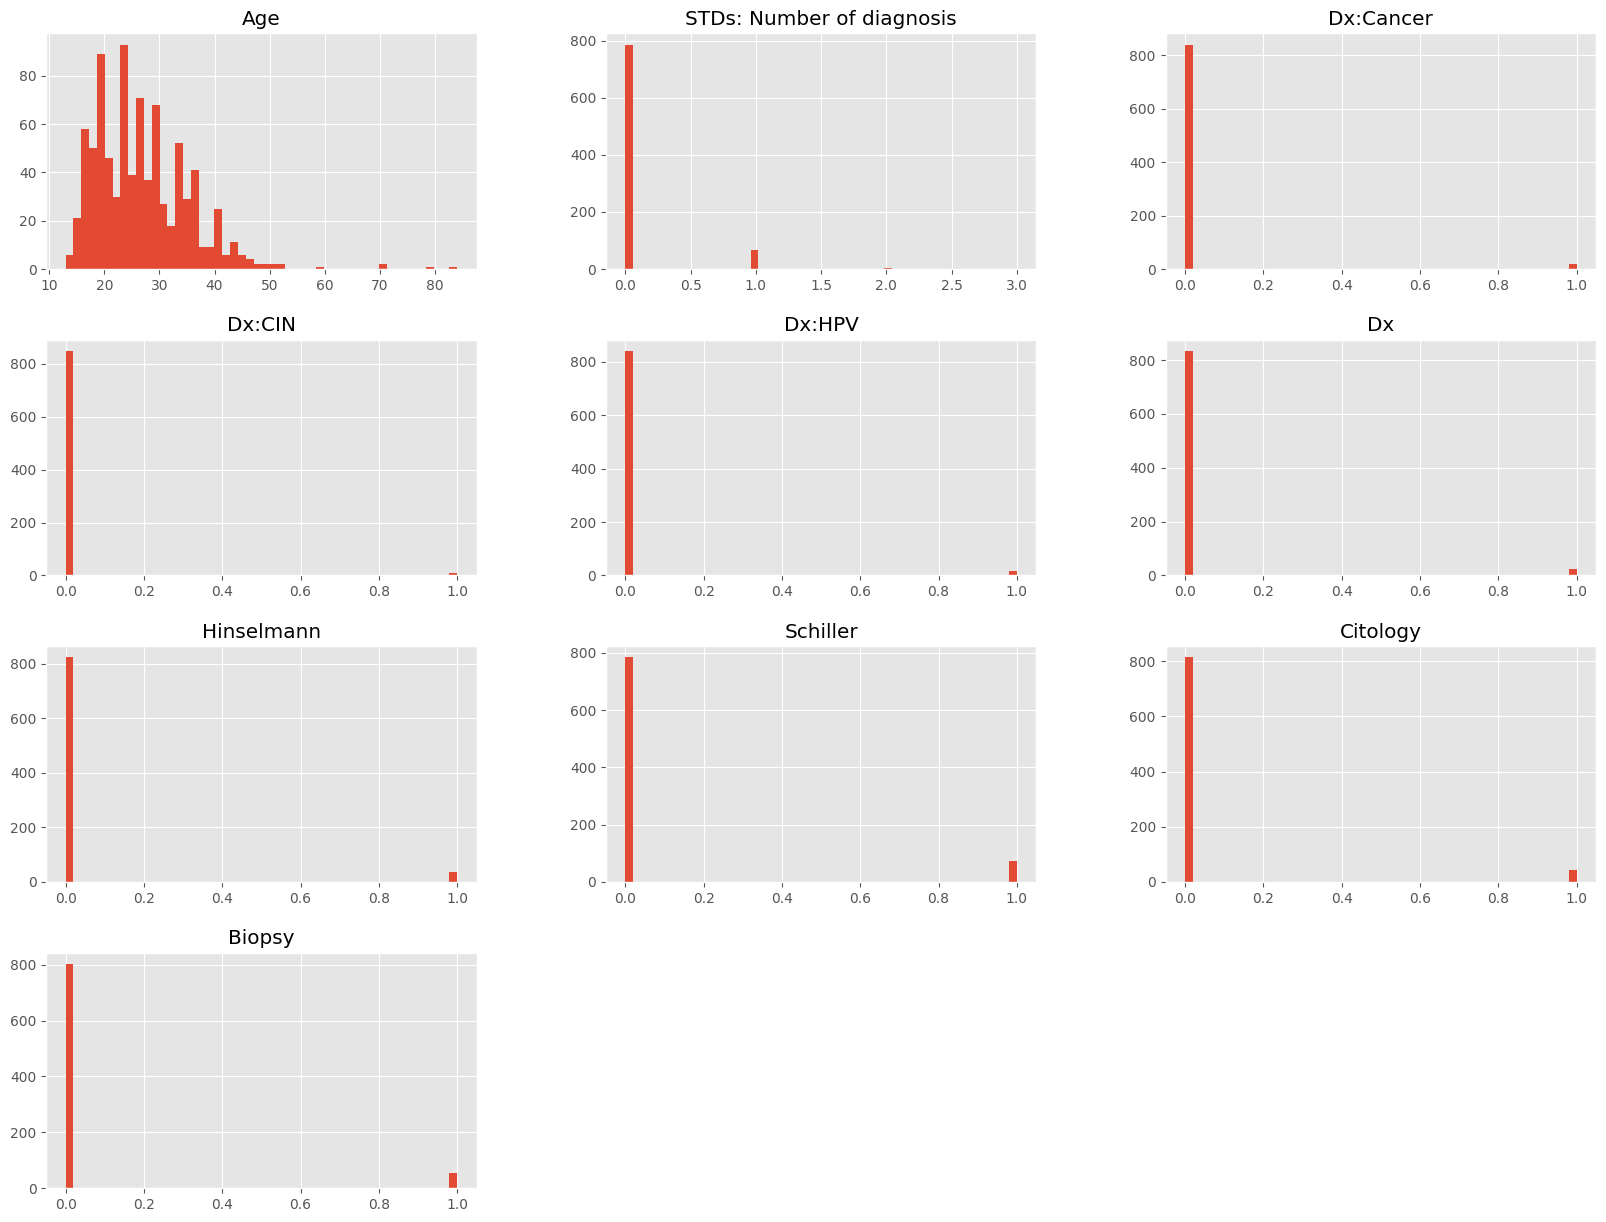

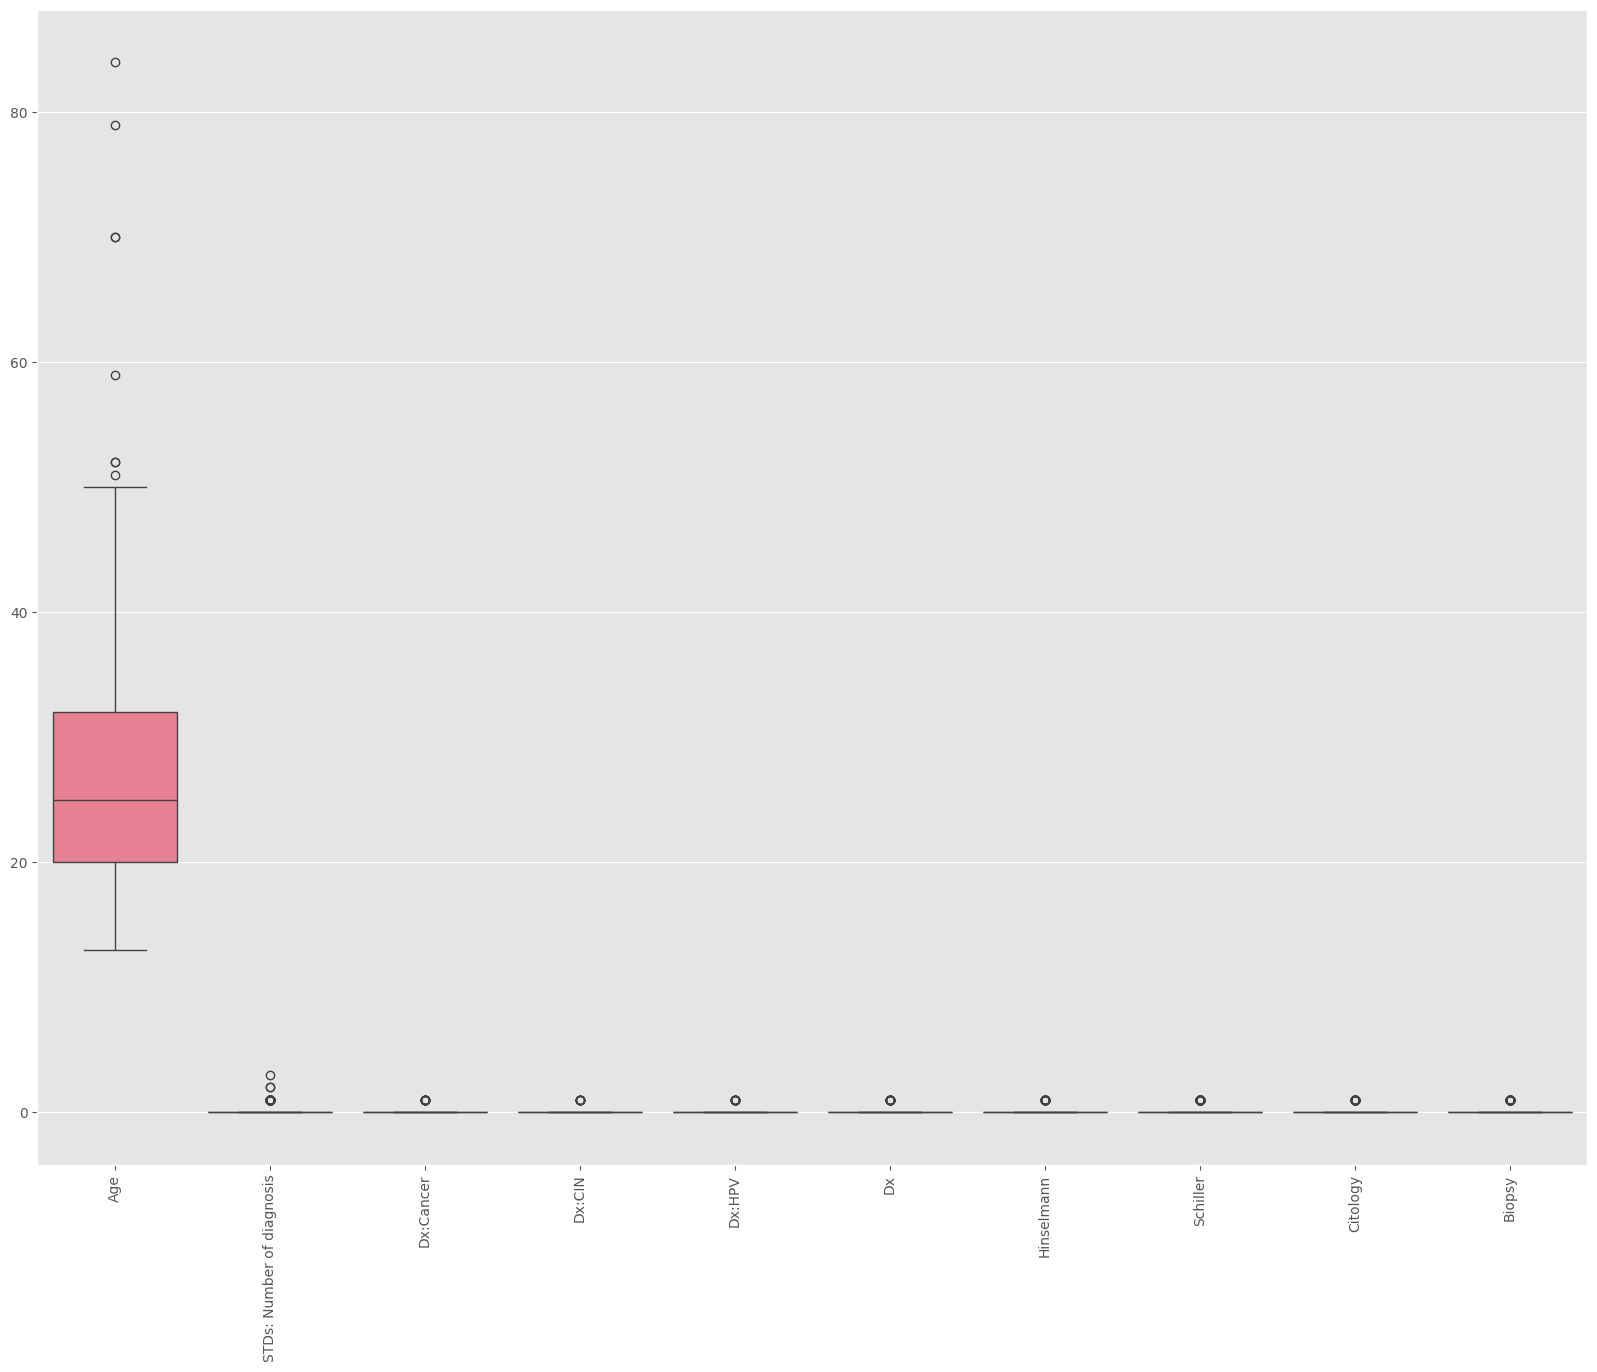

In [4]:
# Histogramas para variables numéricas
df.hist(bins=50, figsize=(20, 15))
plt.show()

# Diagramas de cajas y bigotes para variables numéricas
plt.figure(figsize=(20, 15))
sns.boxplot(data=df.select_dtypes(include=[np.number]))
plt.xticks(rotation=90)
plt.show()

In [5]:
# Matriz de correlación
corr_matrix = df.corr()
print(corr_matrix)

# Mapa de calor de la matriz de correlación
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


ValueError: could not convert string to float: '?'

In [ ]:
# Matriz de correlación
corr_matrix = df.corr()
print(corr_matrix)

# Mapa de calor de la matriz de correlación
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [ ]:
# Resumen de valores faltantes
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Imputación con la media para variables numéricas
imputer_mean = SimpleImputer(strategy='mean')
df_num = df.select_dtypes(include=[np.number])
df_num_imputed = pd.DataFrame(imputer_mean.fit_transform(df_num), columns=df_num.columns)

# Imputación con la moda para variables categóricas
imputer_mode = SimpleImputer(strategy='most_frequent')
df_cat = df.select_dtypes(exclude=[np.number])
df_cat_imputed = pd.DataFrame(imputer_mode.fit_transform(df_cat), columns=df_cat.columns)

# Combinar DataFrames
df_imputed = pd.concat([df_num_imputed, df_cat_imputed], axis=1)


In [ ]:
# Tablas de frecuencia para variables categóricas
for column in df_cat.columns:
    print(df[column].value_counts())

# Gráficos de barras para variables categóricas
plt.figure(figsize=(20, 15))
for i, column in enumerate(df_cat.columns, 1):
    plt.subplot(5, 4, i)
    sns.countplot(data=df_cat, x=column)
    plt.xticks(rotation=90)
plt.show()


In [ ]:
# Normalización de los datos numéricos
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_num_imputed)

# Test de esfericidad de Bartlett
chi_square_value, p_value = bartlett(*df_scaled.T)
print(f'Test de esfericidad de Bartlett: chi-square={chi_square_value}, p-value={p_value}')

# KMO (Kaiser-Meyer-Olkin) Test
kmo_all, kmo_model = calculate_kmo(df_scaled)
print(f'Índice KMO: {kmo_model}')

# Realizar PCA
pca = PCA(n_components=0.95)  # Retener el 95% de la varianza
principal_components = pca.fit_transform(df_scaled)

# Explicación de la varianza
explained_variance = pca.explained_variance_ratio_
print(f'Varianza explicada por cada componente: {explained_variance}')
print(f'Varianza total explicada: {explained_variance.sum()}')


In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

# Convertir variables numéricas a categóricas para el algoritmo Apriori
df_apriori = df_imputed.copy()
for column in df_num.columns:
    df_apriori[column] = pd.cut(df_apriori[column], bins=3, labels=['bajo', 'medio', 'alto'])

# Obtener las frecuencias de los ítems
frequent_itemsets = apriori(df_apriori, min_support=0.1, use_colnames=True)

# Obtener reglas de asociación
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)
print(rules)


In [ ]:
# Guardar DataFrame limpio
df_imputed.to_csv('cervical_cancer_cleaned.csv', index=False)

# Crear un informe en PDF con los resultados y gráficos
from fpdf import FPDF

class PDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, 'Análisis Exploratorio y Limpieza de Datos', 0, 1, 'C')

    def chapter_title(self, title):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, title, 0, 1, 'L')
        self.ln(10)

    def chapter_body(self, body):
        self.set_font('Arial', '', 12)
        self.multi_cell(0, 10, body)
        self.ln()

pdf = PDF()
pdf.add_page()

pdf.chapter_title('Resumen de Estadísticas Descriptivas')
pdf.chapter_body(df.describe().to_string())

pdf.chapter_title('Matriz de Correlación')
pdf.chapter_body(corr_matrix.to_string())

# Guardar el PDF
pdf.output('informe_analisis_exploratorio.pdf')
